# ON/OFF theta2 and alpha plot

This notebook produces both the theta2 plot and the alpha plot of a set of DL2 files.

It extracts automatically also the time duration, given a set of DL2 files merged run-wise.

Input:
- merged DL2 run files (run-wise)
- merged ON and merged all DL2 files
- run numbers
- selection cuts


In [65]:
__authors__ =  'Ruben Lopez, Luca Foffano' #  ruben.lopezcoto@pd.infn.it, luca.foffano@unige.ch
__version__ = '3.08.2020'


# it provides theta2 plot and estimation of run duration

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lstchain.reco.utils import reco_source_position_sky, radec_to_camera

from lstchain.tests.test_lstchain import dl2_file, dl2_params_lstcam_key
from astropy.coordinates import SkyCoord
import astropy.units as u
from gammapy.stats import WStatCountsStatistic


plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 20

######################################################################################

# SELECTION CUTS

intensity_cut = 200
leakage_cut = 0.2
wl_cut = 0.01  
gammaness_cut = 0.8
n_pixels_cut = 1800    # 1800
r_cut = 1

theta2_cut =  0.1

alpha_cut = 8.  



# INPUT FILES

runs_on = [1874, 1875, 1876,  1878, 1879, 1880] 
runs_off = [1877, 1881] 

#  path to the DL2 merged files - per run - e.g. merged-dl2-run1880.h5
path_runs = '../data/crab_on_off/'


# ON and OFF data files (each one obtained merging all ON or OFF files)

on_data_file = '../data/crab_on_off/crab_on/dl2_Run01874_merged.h5'

off_data_file = '../data/crab_on_off/crab_off/dl2_Run01881_merged.h5' 


# reads files - takes some minutes

on_data = pd.read_hdf(on_data_file, key=dl2_params_lstcam_key)
off_data = pd.read_hdf(off_data_file, key=dl2_params_lstcam_key)

In [66]:
# run duration estimation

print("Evaluating run duration...\n")

on_obstime_start = pd.to_datetime(on_data['dragon_time'][0], unit='s')
on_obstime_end = pd.to_datetime(on_data['dragon_time'][len(on_data)-1], unit='s')
print("duration: {:.1f} min".format((on_obstime_end - on_obstime_start).total_seconds()/60)  )
total_obs_duration_on = (on_obstime_end - on_obstime_start).total_seconds()

print("ON data total duration: {:.1f} s  =  {:.1f} min\n".format(total_obs_duration_on, 
                                                                 total_obs_duration_on/60))


#####################################

off_obstime_start = pd.to_datetime(off_data['dragon_time'][0], unit='s')
off_obstime_end = pd.to_datetime(off_data['dragon_time'][len(off_data)-1], unit='s')
print("duration: {:.1f} min".format((off_obstime_end - off_obstime_start).total_seconds()/60)  )
total_obs_duration_off = (off_obstime_end - off_obstime_start).total_seconds()


print("OFF data total duration: {:.1f} s  =  {:.1f} min\n".format(total_obs_duration_off, 
                                                                 total_obs_duration_off/60))



Evaluating run duration...

duration: 20.1 min
ON data total duration: 1203.6 s  =  20.1 min

duration: 20.3 min
OFF data total duration: 1218.3 s  =  20.3 min



In [67]:
#####################################################################

# ON computation

source_position = [0,0]    # assuming source located in the m_tocamera center

m_to_deg = np.rad2deg(np.arctan(1./28))  # conversion from deg / m

Tot_Non = np.shape(on_data)[0]
print("Total number of ON events", Tot_Non)

selection_cuts_on_data = np.array([
                    (on_data['leakage_intensity_width_2'] < leakage_cut) 
                    & (on_data['intensity'] > intensity_cut) 
                    & (on_data['n_pixels'] < n_pixels_cut)
                    & (on_data['wl'] > wl_cut) 
                    & (on_data['gammaness'] > gammaness_cut)
                    & (on_data['r'] < r_cut) 
                    ])[0]

print('Number of ON events after cuts', np.sum(selection_cuts_on_data))

reco_src_x = on_data['reco_src_x'][selection_cuts_on_data]
reco_src_y = on_data['reco_src_y'][selection_cuts_on_data]

on_data['theta2'] = m_to_deg**2 * ((source_position[0] - reco_src_x)**2 + (source_position[1] - reco_src_y)**2)
theta2 = np.array(on_data['theta2'])

Total number of ON events 8215768
Number of ON events after cuts 3431


In [68]:

#####################################################################################

# OFF computation

selection_cuts_off_data = np.array([
                    (off_data['leakage_intensity_width_2'] < leakage_cut) 
                    & (off_data['intensity'] > intensity_cut) 
                    & (off_data['n_pixels'] < n_pixels_cut)
                    & (off_data['wl'] > wl_cut) 
                    & (off_data['gammaness'] > gammaness_cut)  
                    & (off_data['r'] < r_cut)
                    ])[0]


Tot_Noff = np.shape(off_data)[0]
print("Total number of OFF events", Tot_Noff)
print('Number of OFF events after cuts', np.sum(selection_cuts_off_data))

reco_src_x_off = off_data['reco_src_x'][selection_cuts_off_data]
reco_src_y_off = off_data['reco_src_y'][selection_cuts_off_data]

off_data['theta2'] = m_to_deg**2 * ((reco_src_x_off)**2 + (reco_src_y_off)**2) 

theta2_off = np.array(off_data['theta2'])


Total number of OFF events 9116083
Number of OFF events after cuts 2571


In [69]:

# normalization theta2
norm_range_th2_min = 0.5
norm_range_th2_max = 2.


Non_norm = np.sum((theta2 > norm_range_th2_min) & (theta2 < norm_range_th2_max))
Noff_norm = np.sum((theta2_off > norm_range_th2_min) & (theta2_off < norm_range_th2_max))

Norm_theta2 = Non_norm / Noff_norm

print("Normalization: {:.2f}".format(Norm_theta2))

Non = np.sum(theta2 < theta2_cut)
Noff = np.sum(theta2_off < theta2_cut)
Nex = Non - Noff * Norm_theta2

print("Non, Noff, Nex = {:.0f}, {:.0f}, {:.0f}".format(Non, Noff,Nex))

S = Nex / np.sqrt(Noff)
stat = WStatCountsStatistic(Non, Noff, Norm_alpha)
lima_significance = stat.sqrt_ts.item()

#print("\nSignificance: {:.2f}".format(S))
print("Significance Li&Ma: {:.2f}".format(lima_significance))

Normalization: 1.21
Non, Noff, Nex = 288, 66, 208
Significance Li&Ma: 10.19


/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


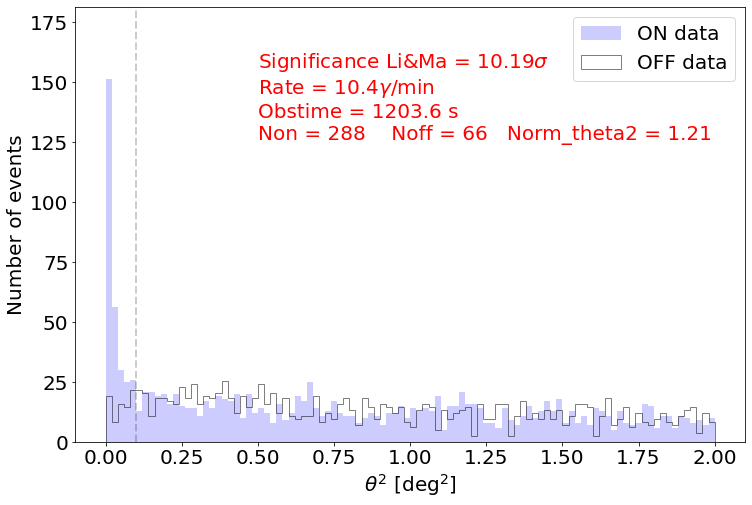

In [70]:
# theta2 plot

nbins = 100
range_max = 2   # deg2


########################################################
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

h_on = ax.hist(theta2,  label = 'ON data', bins=nbins, alpha=0.2, color = 'blue', range=[0,range_max])   #  color = 'C3',
h_off = ax.hist(theta2_off, weights = Norm_theta2 * np.ones(len(theta2_off)), range=[0,range_max],
                 histtype='step', label = 'OFF data', bins=nbins, alpha=0.5, color = 'k')

ax.annotate(s=f'Significance Li&Ma = {lima_significance:.2f}' \
            f'$\sigma$\nRate = {Nex/total_obs_duration_on * 60:.1f}' \
            f'$\gamma$/min  \nObstime = {total_obs_duration_on:.1f} s\nNon = {Non}    Noff = {Noff}   Norm_theta2 = {Norm_theta2:.2f}', 
           xy=(np.max(h_on[1]/4), np.max(h_on[0]/6*5)), size = 20, color = 'r')

ax.vlines(x = theta2_cut, ymin = 0, ymax = np.max(h_on[0]*1.2), linestyle='--', linewidth = 2, color = 'black', alpha = 0.2)


ax.set_xlabel(r'$\theta^2$ [deg$^2$]')
ax.set_ylabel(r'Number of events')
ax.set_ylim(0,np.max(h_on[0]*1.2))
ax.legend()